In [1]:
import joblib
import gzip
import pandas
import pickle
import seaborn
import tqdm

from lib.models.generic_v0.model import map_params

In [2]:
import sys

util_dir = "./sprint-0-explicit-mdps/"
sys.path.append(util_dir)

import util

In [3]:
mdps = pandas.read_pickle("5-generated-mdps/fixed.pkl.gz")
mdps

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,time_spent,rss,mdp
0,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,4,18,0.000616,0.175484,27186b8b
1,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,4,15,0.000429,0.183880,7604fec8
2,v1,generic-v1,False,False,True,True,True,bitcoin,4,26,0.014376,0.183880,7bbe74df
3,v1,generic-v1,False,False,True,True,True,ethereum_3,4,55,0.029269,0.229248,f2e913f9
4,v1,generic-v1,False,False,True,True,True,byzantium_3,4,55,0.032133,0.227905,2a330128
5,v1,generic-v1,False,False,True,True,True,ghostdag_3,4,352,0.170751,0.229103,170c6988
6,v1,generic-v1,False,False,True,True,True,parallel_3,4,206,0.082394,0.245342,58ef7aaf
7,v1+fc,generic-v1,True,False,True,True,True,bitcoin,4,31,0.013185,0.228882,ecb1a34b
8,v1+fc,generic-v1,True,False,True,True,True,ethereum_3,4,52,0.026929,0.236061,f1a86ee9
9,v1+fc,generic-v1,True,False,True,True,True,byzantium_3,4,52,0.035271,0.237446,119aec2a


In [4]:
networks = []
# for alpha in range(35, 41, 5):
for alpha in range(5, 51, 5):
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [5]:
horizon = 100
stop_delta = (
    0.0001  # value iteration stops when no value estimate changes more than this value
)

In [6]:
def optimize(network, idx, row):
    with gzip.open(f"5-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
        emdp = pickle.load(f)
        emdp = map_params(emdp, **network)
        oae = util.optimize_and_evaluate(emdp, eps=stop_delta, horizon=horizon)
        return row.to_dict() | dict(horizon=horizon) | network | oae


def generate_jobs():
    for network in networks:
        for idx, row in mdps.iterrows():
            # if row['size'] > 1000:
            #    continue
            yield joblib.delayed(optimize)(network, idx, row)


jobs = list(generate_jobs())
generate_solutions = joblib.Parallel(return_as="generator_unordered", n_jobs=6)(jobs)
with_progress = tqdm.tqdm(generate_solutions, total=len(jobs))
df = pandas.DataFrame(with_progress)
df.to_pickle("5-value-iterations.pkl.gz")
df

100%|███████████████████████████████████████████████████████████████████████████████████████| 960/960 [04:15<00:00,  3.76it/s]


,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,...,vi_time,vi_max_value,ss_reachable,ss_nonzero,ss_time,pe_iter,ptrev,rpp,time,vi_steady_value
0,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,4,18,...,0.072323,7.771851,5,3,0.048618,2,0.049500,0.050000,0.122281,4.940165
1,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,4,15,...,0.085481,7.771451,6,6,0.047000,2,0.024750,0.050000,0.132944,4.939711
2,v1,generic-v1,False,False,True,True,True,parallel_3,4,206,...,0.739087,8.506424,81,81,0.001832,2,0.023429,0.050000,0.743653,4.878068
3,v1,generic-v1,False,False,True,True,True,ghostdag_3,4,352,...,1.242433,8.577866,6,6,0.058736,2,0.024146,0.050000,1.308016,4.952821
4,v1+fc,generic-v1,True,False,True,True,True,bitcoin,4,31,...,1.741709,98.792295,3,3,0.000967,2,0.047143,1.000000,1.743342,98.790392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,v0,generic-v0,False,False,True,True,True,bitcoin,4,1198,...,20.019235,61.580242,39,39,0.001285,2,0.170215,0.610649,20.075221,60.567219
956,v0+fc+n,generic-v0,True,True,True,True,True,bitcoin,4,104,...,1.221611,66.923274,29,29,0.001266,2,0.224633,0.665339,1.225025,65.944847
957,v0,generic-v0,False,False,True,True,True,bitcoin,4,1198,...,18.870548,61.580242,39,39,0.001242,2,0.170215,0.610649,18.920334,60.567219
958,v0,generic-v0,False,False,True,True,True,bitcoin,4,1198,...,16.830762,66.916471,39,39,0.001055,2,0.181476,0.665339,16.876367,66.022267


  1%|█                                                                                                                       | 4/480 [00:10<27:24,  3.46s/it]

  1%|█▎                                                                                                                      | 5/480 [00:15<32:31,  4.11s/it]

  1%|█▌                                                                                                                      | 6/480 [00:22<40:26,  5.12s/it]

  1%|█▋                                                                                                                    | 7/480 [00:35<1:00:34,  7.68s/it]

  2%|█▉                                                                                                                    | 8/480 [00:51<1:20:43, 10.26s/it]

  2%|██▏                                                                                                                   | 9/480 [01:12<1:46:44, 13.60s/it]

  2%|██▍                                                                                                                  | 10/480 [01:46<2:35:03, 19.79s/it]

  2%|██▋                                                                                                                  | 11/480 [02:03<2:29:26, 19.12s/it]

  2%|██▉                                                                                                                  | 12/480 [02:12<2:04:33, 15.97s/it]

  3%|███▏                                                                                                                 | 13/480 [02:14<1:30:44, 11.66s/it]

  3%|███▍                                                                                                                 | 14/480 [02:16<1:08:18,  8.80s/it]

  3%|███▋                                                                                                                   | 15/480 [02:17<50:22,  6.50s/it]

  3%|███▉                                                                                                                   | 16/480 [02:19<40:13,  5.20s/it]

  4%|████▏                                                                                                                  | 17/480 [02:21<32:09,  4.17s/it]

  4%|████▍                                                                                                                  | 18/480 [02:23<26:34,  3.45s/it]

  4%|████▋                                                                                                                  | 19/480 [02:25<24:15,  3.16s/it]

  4%|████▉                                                                                                                  | 20/480 [02:26<17:30,  2.28s/it]

  4%|█████▏                                                                                                                 | 21/480 [02:26<12:45,  1.67s/it]

  5%|█████▍                                                                                                                 | 22/480 [02:44<49:37,  6.50s/it]

  5%|█████▌                                                                                                               | 23/480 [02:56<1:04:02,  8.41s/it]

  5%|█████▉                                                                                                                 | 24/480 [03:03<59:27,  7.82s/it]

  5%|██████                                                                                                               | 25/480 [03:31<1:44:52, 13.83s/it]

  5%|██████▎                                                                                                              | 26/480 [04:23<3:11:28, 25.31s/it]

  6%|██████▌                                                                                                              | 27/480 [04:26<2:20:23, 18.60s/it]

  6%|██████▊                                                                                                              | 28/480 [04:32<1:51:23, 14.79s/it]

  6%|███████                                                                                                              | 29/480 [04:37<1:30:22, 12.02s/it]

  6%|███████▎                                                                                                             | 30/480 [04:43<1:16:14, 10.17s/it]

  6%|███████▋                                                                                                               | 31/480 [04:45<57:03,  7.62s/it]

  7%|███████▊                                                                                                             | 32/480 [04:55<1:03:01,  8.44s/it]

  7%|████████                                                                                                             | 33/480 [05:23<1:45:34, 14.17s/it]

  7%|████████▎                                                                                                            | 34/480 [05:46<2:07:02, 17.09s/it]

  7%|████████▌                                                                                                            | 35/480 [05:50<1:37:34, 13.16s/it]

  8%|████████▊                                                                                                            | 36/480 [05:54<1:15:08, 10.16s/it]

  8%|█████████▏                                                                                                             | 37/480 [05:55<56:22,  7.63s/it]

  8%|█████████▍                                                                                                             | 38/480 [05:59<46:22,  6.30s/it]

  8%|█████████▋                                                                                                             | 39/480 [05:59<33:41,  4.58s/it]

  8%|█████████▉                                                                                                             | 40/480 [06:01<28:33,  3.89s/it]

  9%|██████████▏                                                                                                            | 41/480 [06:02<21:20,  2.92s/it]

  9%|██████████▍                                                                                                            | 42/480 [06:04<20:13,  2.77s/it]

  9%|██████████▋                                                                                                            | 43/480 [06:06<17:21,  2.38s/it]

  9%|██████████▉                                                                                                            | 44/480 [06:06<12:45,  1.75s/it]

  9%|███████████▏                                                                                                           | 45/480 [06:07<09:49,  1.36s/it]

 10%|███████████▍                                                                                                           | 46/480 [06:15<24:26,  3.38s/it]

 10%|███████████▍                                                                                                         | 47/480 [06:36<1:03:05,  8.74s/it]

 10%|███████████▋                                                                                                         | 48/480 [06:44<1:01:53,  8.60s/it]

 10%|███████████▉                                                                                                         | 49/480 [08:41<4:54:03, 40.94s/it]

 10%|████████████▏                                                                                                        | 50/480 [09:41<5:35:12, 46.77s/it]

 11%|████████████▍                                                                                                        | 51/480 [09:44<4:01:03, 33.71s/it]

 11%|████████████▋                                                                                                        | 52/480 [09:51<3:03:01, 25.66s/it]

 11%|████████████▉                                                                                                        | 53/480 [09:57<2:20:36, 19.76s/it]

 11%|█████████████▏                                                                                                       | 54/480 [09:57<1:38:25, 13.86s/it]

 11%|█████████████▍                                                                                                       | 55/480 [09:59<1:13:19, 10.35s/it]

 12%|█████████████▋                                                                                                       | 56/480 [10:06<1:04:22,  9.11s/it]

 12%|██████████████▏                                                                                                        | 57/480 [10:12<57:28,  8.15s/it]

 12%|██████████████▏                                                                                                      | 58/480 [10:31<1:21:45, 11.63s/it]

 12%|██████████████▍                                                                                                      | 59/480 [10:43<1:21:12, 11.57s/it]

 12%|██████████████▉                                                                                                        | 60/480 [10:43<56:57,  8.14s/it]

 13%|███████████████                                                                                                        | 61/480 [10:45<44:14,  6.34s/it]

 13%|███████████████▎                                                                                                       | 62/480 [10:49<39:52,  5.72s/it]

 13%|███████████████▌                                                                                                       | 63/480 [10:53<34:32,  4.97s/it]

 13%|███████████████▊                                                                                                       | 64/480 [10:54<26:23,  3.81s/it]

 14%|████████████████                                                                                                       | 65/480 [10:56<22:59,  3.32s/it]

 14%|████████████████▎                                                                                                      | 66/480 [10:57<18:18,  2.65s/it]

 14%|████████████████▌                                                                                                      | 67/480 [11:00<19:29,  2.83s/it]

 14%|████████████████▊                                                                                                      | 68/480 [11:00<14:10,  2.06s/it]

 14%|█████████████████                                                                                                      | 69/480 [11:01<10:25,  1.52s/it]

 15%|█████████████████▎                                                                                                     | 70/480 [11:11<27:58,  4.09s/it]

 15%|█████████████████▌                                                                                                     | 71/480 [11:14<26:47,  3.93s/it]

 15%|█████████████████▌                                                                                                   | 72/480 [11:39<1:09:47, 10.26s/it]

 15%|█████████████████▊                                                                                                   | 73/480 [13:41<4:56:27, 43.70s/it]

 15%|██████████████████                                                                                                   | 74/480 [14:16<4:38:21, 41.14s/it]

 16%|██████████████████▎                                                                                                  | 75/480 [14:20<3:21:07, 29.80s/it]

 16%|██████████████████▌                                                                                                  | 76/480 [14:26<2:34:21, 22.92s/it]

 16%|██████████████████▊                                                                                                  | 77/480 [14:33<2:00:07, 17.88s/it]

 16%|███████████████████                                                                                                  | 78/480 [14:36<1:30:48, 13.55s/it]

 16%|███████████████████▎                                                                                                 | 79/480 [14:41<1:13:47, 11.04s/it]

 17%|███████████████████▊                                                                                                   | 80/480 [14:42<53:15,  7.99s/it]

 17%|████████████████████                                                                                                   | 81/480 [14:50<52:38,  7.92s/it]

 17%|████████████████████▎                                                                                                  | 82/480 [14:50<37:56,  5.72s/it]

 17%|████████████████████▏                                                                                                | 83/480 [15:25<1:34:19, 14.26s/it]

 18%|████████████████████▍                                                                                                | 84/480 [15:35<1:25:56, 13.02s/it]

 18%|████████████████████▋                                                                                                | 85/480 [15:37<1:03:54,  9.71s/it]

 18%|█████████████████████▎                                                                                                 | 86/480 [15:39<49:08,  7.48s/it]

 18%|█████████████████████▌                                                                                                 | 87/480 [15:40<37:11,  5.68s/it]

 18%|█████████████████████▊                                                                                                 | 88/480 [15:43<30:10,  4.62s/it]

 19%|██████████████████████                                                                                                 | 89/480 [15:45<24:48,  3.81s/it]

 19%|██████████████████████▎                                                                                                | 90/480 [15:46<20:59,  3.23s/it]

 19%|██████████████████████▌                                                                                                | 91/480 [15:49<20:24,  3.15s/it]

 19%|██████████████████████▊                                                                                                | 92/480 [15:50<14:46,  2.29s/it]

 20%|███████████████████████▎                                                                                               | 94/480 [15:50<08:18,  1.29s/it]

 20%|███████████████████████▌                                                                                               | 95/480 [15:51<07:58,  1.24s/it]

 20%|███████████████████████▊                                                                                               | 96/480 [15:58<16:48,  2.63s/it]

 20%|███████████████████████▋                                                                                             | 97/480 [18:41<4:55:12, 46.25s/it]

 20%|███████████████████████▉                                                                                             | 98/480 [19:29<4:57:42, 46.76s/it]

 21%|████████████████████████▏                                                                                            | 99/480 [19:32<3:39:08, 34.51s/it]

 21%|████████████████████████▏                                                                                           | 100/480 [19:41<2:50:22, 26.90s/it]

 21%|████████████████████████▍                                                                                           | 101/480 [19:47<2:11:28, 20.81s/it]

 21%|████████████████████████▋                                                                                           | 102/480 [19:47<1:32:42, 14.72s/it]

 21%|████████████████████████▉                                                                                           | 103/480 [19:55<1:20:44, 12.85s/it]

 22%|█████████████████████████▏                                                                                          | 104/480 [20:02<1:08:52, 10.99s/it]

 22%|█████████████████████████▊                                                                                            | 105/480 [20:07<57:45,  9.24s/it]

 22%|██████████████████████████                                                                                            | 106/480 [20:15<54:46,  8.79s/it]

 22%|██████████████████████████▎                                                                                           | 107/480 [20:16<41:15,  6.64s/it]

 22%|██████████████████████████▌                                                                                           | 108/480 [20:28<51:10,  8.25s/it]

 23%|██████████████████████████▊                                                                                           | 109/480 [20:31<39:33,  6.40s/it]

 23%|███████████████████████████                                                                                           | 110/480 [20:34<34:55,  5.66s/it]

 23%|███████████████████████████▎                                                                                          | 111/480 [20:38<30:36,  4.98s/it]

 23%|███████████████████████████▌                                                                                          | 112/480 [20:41<27:55,  4.55s/it]

 24%|███████████████████████████▊                                                                                          | 113/480 [20:43<22:44,  3.72s/it]

 24%|████████████████████████████                                                                                          | 114/480 [20:45<19:50,  3.25s/it]

 24%|████████████████████████████▎                                                                                         | 115/480 [20:48<19:26,  3.20s/it]

 24%|████████████████████████████▌                                                                                         | 116/480 [20:49<14:06,  2.33s/it]

 24%|████████████████████████████▊                                                                                         | 117/480 [20:49<10:20,  1.71s/it]

 25%|█████████████████████████████                                                                                         | 118/480 [21:13<50:25,  8.36s/it]

 25%|█████████████████████████████▎                                                                                        | 119/480 [21:20<47:42,  7.93s/it]

 25%|█████████████████████████████▌                                                                                        | 120/480 [21:29<50:04,  8.35s/it]

 25%|█████████████████████████████▏                                                                                      | 121/480 [23:41<4:31:42, 45.41s/it]

 25%|█████████████████████████████▍                                                                                      | 122/480 [24:46<5:06:28, 51.36s/it]

 26%|█████████████████████████████▋                                                                                      | 123/480 [24:50<3:40:07, 36.99s/it]

 26%|█████████████████████████████▉                                                                                      | 124/480 [24:58<2:48:07, 28.34s/it]

 26%|██████████████████████████████▏                                                                                     | 125/480 [24:58<1:58:23, 20.01s/it]

 26%|██████████████████████████████▍                                                                                     | 126/480 [25:04<1:33:03, 15.77s/it]

 26%|██████████████████████████████▋                                                                                     | 127/480 [25:05<1:05:39, 11.16s/it]

 27%|███████████████████████████████▍                                                                                      | 128/480 [25:07<49:58,  8.52s/it]

 27%|███████████████████████████████▋                                                                                      | 129/480 [25:19<55:10,  9.43s/it]

 27%|███████████████████████████████▍                                                                                    | 130/480 [25:31<1:00:37, 10.39s/it]

 27%|███████████████████████████████▋                                                                                    | 131/480 [25:46<1:08:00, 11.69s/it]

 28%|████████████████████████████████▍                                                                                     | 132/480 [25:51<56:40,  9.77s/it]

 28%|████████████████████████████████▋                                                                                     | 133/480 [25:53<43:06,  7.45s/it]

 28%|████████████████████████████████▉                                                                                     | 134/480 [25:57<36:02,  6.25s/it]

 28%|█████████████████████████████████▏                                                                                    | 135/480 [25:57<26:10,  4.55s/it]

 28%|█████████████████████████████████▍                                                                                    | 136/480 [26:00<22:55,  4.00s/it]

 29%|█████████████████████████████████▋                                                                                    | 137/480 [26:01<17:15,  3.02s/it]

 29%|█████████████████████████████████▉                                                                                    | 138/480 [26:04<16:49,  2.95s/it]

 29%|██████████████████████████████████▏                                                                                   | 139/480 [26:06<16:17,  2.87s/it]

 29%|██████████████████████████████████▍                                                                                   | 140/480 [26:07<11:56,  2.11s/it]

 29%|██████████████████████████████████▋                                                                                   | 141/480 [26:07<08:48,  1.56s/it]

 30%|██████████████████████████████████▉                                                                                   | 142/480 [26:23<33:21,  5.92s/it]

 30%|███████████████████████████████████▏                                                                                  | 143/480 [26:27<30:19,  5.40s/it]

 30%|███████████████████████████████████▍                                                                                  | 144/480 [26:48<55:25,  9.90s/it]

 30%|███████████████████████████████████                                                                                 | 145/480 [29:11<4:38:12, 49.83s/it]

 30%|███████████████████████████████████▎                                                                                | 146/480 [30:19<5:08:06, 55.35s/it]

 31%|███████████████████████████████████▌                                                                                | 147/480 [30:20<3:36:15, 38.97s/it]

 31%|███████████████████████████████████▊                                                                                | 148/480 [30:23<2:36:27, 28.27s/it]

 31%|████████████████████████████████████                                                                                | 149/480 [30:28<1:57:59, 21.39s/it]

 31%|████████████████████████████████████▎                                                                               | 150/480 [30:29<1:24:14, 15.32s/it]

 31%|████████████████████████████████████▍                                                                               | 151/480 [30:37<1:11:00, 12.95s/it]

 32%|████████████████████████████████████▋                                                                               | 152/480 [30:44<1:01:44, 11.29s/it]

 32%|█████████████████████████████████████▌                                                                                | 153/480 [30:49<51:18,  9.41s/it]

 32%|█████████████████████████████████████▏                                                                              | 154/480 [31:11<1:10:36, 13.00s/it]

 32%|█████████████████████████████████████▍                                                                              | 155/480 [31:27<1:16:16, 14.08s/it]

 32%|█████████████████████████████████████▋                                                                              | 156/480 [31:33<1:03:00, 11.67s/it]

 33%|██████████████████████████████████████▌                                                                               | 157/480 [31:36<47:53,  8.90s/it]

 33%|██████████████████████████████████████▊                                                                               | 158/480 [31:40<40:51,  7.61s/it]

 33%|███████████████████████████████████████                                                                               | 159/480 [31:40<28:45,  5.37s/it]

 33%|███████████████████████████████████████▎                                                                              | 160/480 [31:44<25:31,  4.79s/it]

 34%|███████████████████████████████████████▌                                                                              | 161/480 [31:44<18:32,  3.49s/it]

 34%|███████████████████████████████████████▊                                                                              | 162/480 [31:48<18:12,  3.44s/it]

 34%|████████████████████████████████████████                                                                              | 163/480 [31:50<16:28,  3.12s/it]

 34%|████████████████████████████████████████▎                                                                             | 164/480 [31:50<12:00,  2.28s/it]

 34%|████████████████████████████████████████▌                                                                             | 165/480 [31:51<08:49,  1.68s/it]

 35%|████████████████████████████████████████▊                                                                             | 166/480 [31:58<17:40,  3.38s/it]

 35%|█████████████████████████████████████████                                                                             | 167/480 [32:15<38:40,  7.41s/it]

 35%|█████████████████████████████████████████▎                                                                            | 168/480 [32:33<55:42, 10.71s/it]

 35%|████████████████████████████████████████▊                                                                           | 169/480 [34:52<4:14:28, 49.09s/it]

 35%|█████████████████████████████████████████                                                                           | 170/480 [36:00<4:43:59, 54.96s/it]

 36%|█████████████████████████████████████████▎                                                                          | 171/480 [36:04<3:24:02, 39.62s/it]

 36%|█████████████████████████████████████████▌                                                                          | 172/480 [36:09<2:30:19, 29.28s/it]

 36%|█████████████████████████████████████████▊                                                                          | 173/480 [36:13<1:50:15, 21.55s/it]

 36%|██████████████████████████████████████████                                                                          | 174/480 [36:16<1:21:54, 16.06s/it]

 36%|██████████████████████████████████████████▎                                                                         | 175/480 [36:22<1:05:20, 12.85s/it]

 37%|██████████████████████████████████████████▌                                                                         | 176/480 [36:31<1:00:33, 11.95s/it]

 37%|███████████████████████████████████████████▌                                                                          | 177/480 [36:35<47:42,  9.45s/it]

 37%|███████████████████████████████████████████▊                                                                          | 178/480 [36:47<51:00, 10.13s/it]

 37%|███████████████████████████████████████████▎                                                                        | 179/480 [37:12<1:14:08, 14.78s/it]

 38%|████████████████████████████████████████████▎                                                                         | 180/480 [37:15<56:13, 11.25s/it]

 38%|████████████████████████████████████████████▍                                                                         | 181/480 [37:18<42:32,  8.54s/it]

 38%|████████████████████████████████████████████▋                                                                         | 182/480 [37:22<36:19,  7.32s/it]

 38%|████████████████████████████████████████████▉                                                                         | 183/480 [37:25<29:13,  5.90s/it]

 38%|█████████████████████████████████████████████▏                                                                        | 184/480 [37:26<22:02,  4.47s/it]

 39%|█████████████████████████████████████████████▍                                                                        | 185/480 [37:28<19:04,  3.88s/it]

 39%|█████████████████████████████████████████████▋                                                                        | 186/480 [37:29<14:55,  3.05s/it]

 39%|█████████████████████████████████████████████▉                                                                        | 187/480 [37:33<16:04,  3.29s/it]

 39%|██████████████████████████████████████████████▏                                                                       | 188/480 [37:34<11:43,  2.41s/it]

 39%|██████████████████████████████████████████████▍                                                                       | 189/480 [37:34<08:43,  1.80s/it]

 40%|██████████████████████████████████████████████▋                                                                       | 190/480 [37:50<29:48,  6.17s/it]

 40%|██████████████████████████████████████████████▉                                                                       | 191/480 [37:58<31:42,  6.58s/it]

 40%|███████████████████████████████████████████████▏                                                                      | 192/480 [38:10<39:23,  8.21s/it]

 40%|██████████████████████████████████████████████▋                                                                     | 193/480 [40:53<4:21:50, 54.74s/it]

 40%|██████████████████████████████████████████████▉                                                                     | 194/480 [42:02<4:40:52, 58.93s/it]

 41%|███████████████████████████████████████████████▏                                                                    | 195/480 [42:05<3:21:02, 42.32s/it]

 41%|███████████████████████████████████████████████▌                                                                    | 197/480 [42:13<1:55:22, 24.46s/it]

 41%|███████████████████████████████████████████████▊                                                                    | 198/480 [42:15<1:29:17, 19.00s/it]

 41%|████████████████████████████████████████████████                                                                    | 199/480 [42:22<1:13:36, 15.72s/it]

 42%|████████████████████████████████████████████████▎                                                                   | 200/480 [42:30<1:03:53, 13.69s/it]

 42%|████████████████████████████████████████████████▌                                                                   | 201/480 [42:45<1:05:00, 13.98s/it]

 42%|████████████████████████████████████████████████▊                                                                   | 202/480 [43:10<1:20:21, 17.34s/it]

 42%|█████████████████████████████████████████████████                                                                   | 203/480 [43:13<1:00:01, 13.00s/it]

 42%|██████████████████████████████████████████████████▏                                                                   | 204/480 [43:16<46:31, 10.11s/it]

 43%|██████████████████████████████████████████████████▍                                                                   | 205/480 [43:18<36:07,  7.88s/it]

 43%|██████████████████████████████████████████████████▋                                                                   | 206/480 [43:24<32:48,  7.18s/it]

 43%|██████████████████████████████████████████████████▉                                                                   | 207/480 [43:26<25:10,  5.53s/it]

 43%|███████████████████████████████████████████████████▏                                                                  | 208/480 [43:28<20:16,  4.47s/it]

 44%|███████████████████████████████████████████████████▍                                                                  | 209/480 [43:29<16:19,  3.61s/it]

 44%|███████████████████████████████████████████████████▋                                                                  | 210/480 [43:31<14:13,  3.16s/it]

 44%|███████████████████████████████████████████████████▊                                                                  | 211/480 [43:34<13:33,  3.02s/it]

 44%|████████████████████████████████████████████████████                                                                  | 212/480 [43:34<09:54,  2.22s/it]

 44%|████████████████████████████████████████████████████▎                                                                 | 213/480 [43:35<07:18,  1.64s/it]

 45%|████████████████████████████████████████████████████▌                                                                 | 214/480 [43:57<35:16,  7.96s/it]

 45%|████████████████████████████████████████████████████▊                                                                 | 215/480 [44:11<43:02,  9.75s/it]

 45%|████████████████████████████████████████████████████▏                                                               | 216/480 [44:36<1:03:10, 14.36s/it]

 45%|████████████████████████████████████████████████████▍                                                               | 217/480 [47:17<4:15:27, 58.28s/it]

 45%|████████████████████████████████████████████████████▋                                                               | 218/480 [48:26<4:28:55, 61.58s/it]

 46%|████████████████████████████████████████████████████▉                                                               | 219/480 [48:30<3:11:46, 44.08s/it]

 46%|█████████████████████████████████████████████████████▏                                                              | 220/480 [48:31<2:15:10, 31.20s/it]

 46%|█████████████████████████████████████████████████████▍                                                              | 221/480 [48:38<1:44:10, 24.13s/it]

 46%|█████████████████████████████████████████████████████▉                                                              | 223/480 [48:48<1:05:22, 15.26s/it]

 47%|███████████████████████████████████████████████████████                                                               | 224/480 [48:51<52:03, 12.20s/it]

 47%|███████████████████████████████████████████████████████▎                                                              | 225/480 [48:55<42:43, 10.05s/it]

 47%|██████████████████████████████████████████████████████▌                                                             | 226/480 [49:21<1:00:51, 14.38s/it]

 47%|██████████████████████████████████████████████████████▊                                                             | 227/480 [49:36<1:01:02, 14.47s/it]

 48%|████████████████████████████████████████████████████████                                                              | 228/480 [49:48<58:08, 13.84s/it]

 48%|████████████████████████████████████████████████████████▎                                                             | 229/480 [49:49<41:37,  9.95s/it]

 48%|████████████████████████████████████████████████████████▌                                                             | 230/480 [49:51<32:30,  7.80s/it]

 48%|████████████████████████████████████████████████████████▊                                                             | 231/480 [49:54<26:00,  6.27s/it]

 48%|█████████████████████████████████████████████████████████                                                             | 232/480 [49:56<20:24,  4.94s/it]

 49%|█████████████████████████████████████████████████████████▎                                                            | 233/480 [49:58<17:02,  4.14s/it]

 49%|█████████████████████████████████████████████████████████▌                                                            | 234/480 [49:59<13:34,  3.31s/it]

 49%|█████████████████████████████████████████████████████████▊                                                            | 235/480 [50:03<14:02,  3.44s/it]

 49%|██████████████████████████████████████████████████████████                                                            | 236/480 [50:03<10:10,  2.50s/it]

 49%|██████████████████████████████████████████████████████████▎                                                           | 237/480 [50:03<07:27,  1.84s/it]

 50%|██████████████████████████████████████████████████████████▌                                                           | 238/480 [50:15<19:12,  4.76s/it]

 50%|██████████████████████████████████████████████████████████▊                                                           | 239/480 [50:31<32:09,  8.01s/it]

 50%|███████████████████████████████████████████████████████████                                                           | 240/480 [50:49<44:24, 11.10s/it]

 50%|██████████████████████████████████████████████████████████▏                                                         | 241/480 [53:22<3:33:55, 53.70s/it]

 50%|██████████████████████████████████████████████████████████▍                                                         | 242/480 [54:39<4:00:25, 60.61s/it]

 51%|██████████████████████████████████████████████████████████▋                                                         | 243/480 [54:43<2:52:04, 43.56s/it]

 51%|██████████████████████████████████████████████████████████▉                                                         | 244/480 [54:51<2:10:02, 33.06s/it]

 51%|███████████████████████████████████████████████████████████▏                                                        | 245/480 [54:53<1:32:14, 23.55s/it]

 51%|███████████████████████████████████████████████████████████▍                                                        | 246/480 [54:53<1:05:20, 16.75s/it]

 51%|████████████████████████████████████████████████████████████▋                                                         | 247/480 [54:58<51:10, 13.18s/it]

 52%|████████████████████████████████████████████████████████████▉                                                         | 248/480 [55:02<39:55, 10.33s/it]

 52%|█████████████████████████████████████████████████████████████▏                                                        | 249/480 [55:09<35:41,  9.27s/it]

 52%|████████████████████████████████████████████████████████████▍                                                       | 250/480 [55:53<1:15:57, 19.82s/it]

 52%|████████████████████████████████████████████████████████████▋                                                       | 251/480 [56:04<1:04:52, 17.00s/it]

 52%|█████████████████████████████████████████████████████████████▉                                                        | 252/480 [56:14<56:49, 14.96s/it]

 53%|██████████████████████████████████████████████████████████████▏                                                       | 253/480 [56:16<42:13, 11.16s/it]

 53%|██████████████████████████████████████████████████████████████▋                                                       | 255/480 [56:20<25:51,  6.89s/it]

 53%|██████████████████████████████████████████████████████████████▉                                                       | 256/480 [56:21<20:32,  5.50s/it]

 54%|███████████████████████████████████████████████████████████████▏                                                      | 257/480 [56:24<17:54,  4.82s/it]

 54%|███████████████████████████████████████████████████████████████▍                                                      | 258/480 [56:25<14:06,  3.81s/it]

 54%|███████████████████████████████████████████████████████████████▋                                                      | 259/480 [56:26<10:25,  2.83s/it]

 54%|███████████████████████████████████████████████████████████████▉                                                      | 260/480 [56:26<07:50,  2.14s/it]

 54%|████████████████████████████████████████████████████████████████▏                                                     | 261/480 [56:26<05:53,  1.61s/it]

 55%|████████████████████████████████████████████████████████████████▍                                                     | 262/480 [56:29<07:29,  2.06s/it]

 55%|████████████████████████████████████████████████████████████████▋                                                     | 263/480 [56:53<30:06,  8.33s/it]

 55%|████████████████████████████████████████████████████████████████▉                                                     | 264/480 [57:27<57:48, 16.06s/it]

 55%|██████████████████████████████████████████████████████████████▉                                                   | 265/480 [1:00:41<4:06:59, 68.93s/it]

 55%|███████████████████████████████████████████████████████████████▏                                                  | 266/480 [1:01:57<4:13:38, 71.12s/it]

 56%|███████████████████████████████████████████████████████████████▍                                                  | 267/480 [1:02:02<3:02:11, 51.32s/it]

 56%|███████████████████████████████████████████████████████████████▋                                                  | 268/480 [1:02:04<2:09:05, 36.54s/it]

 56%|███████████████████████████████████████████████████████████████▉                                                  | 269/480 [1:02:12<1:38:59, 28.15s/it]

 56%|████████████████████████████████████████████████████████████████▏                                                 | 270/480 [1:02:14<1:10:09, 20.04s/it]

 56%|█████████████████████████████████████████████████████████████████▍                                                  | 271/480 [1:02:21<57:05, 16.39s/it]

 57%|█████████████████████████████████████████████████████████████████▋                                                  | 272/480 [1:02:27<46:05, 13.30s/it]

 57%|█████████████████████████████████████████████████████████████████▉                                                  | 273/480 [1:02:28<33:09,  9.61s/it]

 57%|██████████████████████████████████████████████████████████████████▏                                                 | 274/480 [1:02:51<46:12, 13.46s/it]

 57%|██████████████████████████████████████████████████████████████████▍                                                 | 275/480 [1:02:56<36:53, 10.80s/it]

 57%|██████████████████████████████████████████████████████████████████▋                                                 | 276/480 [1:03:09<39:12, 11.53s/it]

 58%|██████████████████████████████████████████████████████████████████▉                                                 | 277/480 [1:03:12<30:17,  8.95s/it]

 58%|███████████████████████████████████████████████████████████████████▏                                                | 278/480 [1:03:17<26:31,  7.88s/it]

 58%|███████████████████████████████████████████████████████████████████▍                                                | 279/480 [1:03:21<22:53,  6.84s/it]

 58%|███████████████████████████████████████████████████████████████████▋                                                | 280/480 [1:03:25<19:38,  5.89s/it]

 59%|███████████████████████████████████████████████████████████████████▉                                                | 281/480 [1:03:28<16:57,  5.11s/it]

 59%|████████████████████████████████████████████████████████████████████▏                                               | 282/480 [1:03:30<12:56,  3.92s/it]

 59%|████████████████████████████████████████████████████████████████████▍                                               | 283/480 [1:03:34<13:17,  4.05s/it]

 59%|████████████████████████████████████████████████████████████████████▋                                               | 284/480 [1:03:34<09:41,  2.97s/it]

 59%|████████████████████████████████████████████████████████████████████▉                                               | 285/480 [1:03:35<07:04,  2.18s/it]

 60%|█████████████████████████████████████████████████████████████████████                                               | 286/480 [1:04:01<30:52,  9.55s/it]

 60%|█████████████████████████████████████████████████████████████████████▎                                              | 287/480 [1:04:20<38:57, 12.11s/it]

 60%|█████████████████████████████████████████████████████████████████████▌                                              | 288/480 [1:04:25<32:15, 10.08s/it]

 60%|████████████████████████████████████████████████████████████████████▋                                             | 289/480 [1:07:47<3:34:58, 67.53s/it]

 60%|████████████████████████████████████████████████████████████████████▉                                             | 290/480 [1:08:14<2:55:37, 55.46s/it]

 61%|█████████████████████████████████████████████████████████████████████                                             | 291/480 [1:08:20<2:07:44, 40.55s/it]

 61%|█████████████████████████████████████████████████████████████████████▎                                            | 292/480 [1:08:29<1:37:54, 31.25s/it]

 61%|█████████████████████████████████████████████████████████████████████▌                                            | 293/480 [1:08:37<1:15:50, 24.34s/it]

 61%|█████████████████████████████████████████████████████████████████████▊                                            | 294/480 [1:08:47<1:01:48, 19.94s/it]

 61%|███████████████████████████████████████████████████████████████████████▎                                            | 295/480 [1:09:03<57:45, 18.73s/it]

 62%|███████████████████████████████████████████████████████████████████████▌                                            | 296/480 [1:09:05<42:08, 13.74s/it]

 62%|███████████████████████████████████████████████████████████████████████▊                                            | 297/480 [1:09:24<46:50, 15.36s/it]

 62%|██████████████████████████████████████████████████████████████████████▊                                           | 298/480 [1:10:05<1:10:13, 23.15s/it]

 62%|████████████████████████████████████████████████████████████████████████▎                                           | 299/480 [1:10:12<54:53, 18.20s/it]

 62%|████████████████████████████████████████████████████████████████████████▌                                           | 300/480 [1:10:25<50:13, 16.74s/it]

 63%|████████████████████████████████████████████████████████████████████████▋                                           | 301/480 [1:10:28<37:29, 12.57s/it]

 63%|████████████████████████████████████████████████████████████████████████▉                                           | 302/480 [1:10:34<31:02, 10.46s/it]

 63%|█████████████████████████████████████████████████████████████████████████▏                                          | 303/480 [1:10:35<22:44,  7.71s/it]

 63%|█████████████████████████████████████████████████████████████████████████▍                                          | 304/480 [1:10:38<18:32,  6.32s/it]

 64%|█████████████████████████████████████████████████████████████████████████▋                                          | 305/480 [1:10:39<13:37,  4.67s/it]

 64%|█████████████████████████████████████████████████████████████████████████▉                                          | 306/480 [1:10:42<12:05,  4.17s/it]

 64%|██████████████████████████████████████████████████████████████████████████▏                                         | 307/480 [1:10:45<10:38,  3.69s/it]

 64%|██████████████████████████████████████████████████████████████████████████▍                                         | 308/480 [1:10:45<07:47,  2.72s/it]

 64%|██████████████████████████████████████████████████████████████████████████▋                                         | 309/480 [1:10:45<05:42,  2.00s/it]

 65%|██████████████████████████████████████████████████████████████████████████▉                                         | 310/480 [1:10:55<12:21,  4.36s/it]

 65%|███████████████████████████████████████████████████████████████████████████▏                                        | 311/480 [1:11:03<14:52,  5.28s/it]

 65%|███████████████████████████████████████████████████████████████████████████▍                                        | 312/480 [1:11:45<45:54, 16.39s/it]

 65%|██████████████████████████████████████████████████████████████████████████▎                                       | 313/480 [1:15:26<3:36:47, 77.89s/it]

 65%|██████████████████████████████████████████████████████████████████████████▌                                       | 314/480 [1:16:34<3:26:35, 74.67s/it]

 66%|██████████████████████████████████████████████████████████████████████████▊                                       | 315/480 [1:16:39<2:28:21, 53.95s/it]

 66%|███████████████████████████████████████████████████████████████████████████                                       | 316/480 [1:16:49<1:51:33, 40.81s/it]

 66%|███████████████████████████████████████████████████████████████████████████▎                                      | 317/480 [1:16:50<1:18:02, 28.73s/it]

 66%|███████████████████████████████████████████████████████████████████████████▌                                      | 318/480 [1:16:58<1:00:39, 22.46s/it]

 66%|█████████████████████████████████████████████████████████████████████████████                                       | 319/480 [1:16:59<43:16, 16.13s/it]

 67%|█████████████████████████████████████████████████████████████████████████████▎                                      | 320/480 [1:17:13<41:25, 15.54s/it]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 321/480 [1:17:26<38:49, 14.65s/it]

 67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 322/480 [1:17:31<31:03, 11.79s/it]

 67%|██████████████████████████████████████████████████████████████████████████████                                      | 323/480 [1:18:11<53:29, 20.44s/it]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 324/480 [1:18:17<41:40, 16.03s/it]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 325/480 [1:18:20<31:27, 12.18s/it]

 68%|██████████████████████████████████████████████████████████████████████████████▊                                     | 326/480 [1:18:26<25:52, 10.08s/it]

 68%|███████████████████████████████████████████████████████████████████████████████                                     | 327/480 [1:18:26<18:10,  7.13s/it]

 68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 328/480 [1:18:30<15:37,  6.17s/it]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 329/480 [1:18:30<11:05,  4.41s/it]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 330/480 [1:18:33<10:14,  4.10s/it]

 69%|███████████████████████████████████████████████████████████████████████████████▉                                    | 331/480 [1:18:37<09:35,  3.86s/it]

 69%|████████████████████████████████████████████████████████████████████████████████▏                                   | 332/480 [1:18:37<07:02,  2.85s/it]

 69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 333/480 [1:18:38<05:09,  2.10s/it]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                   | 334/480 [1:19:05<23:43,  9.75s/it]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 335/480 [1:19:08<18:19,  7.58s/it]

 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 336/480 [1:19:13<16:21,  6.82s/it]

 70%|████████████████████████████████████████████████████████████████████████████████                                  | 337/480 [1:23:07<2:58:47, 75.02s/it]

 70%|████████████████████████████████████████████████████████████████████████████████▎                                 | 338/480 [1:24:32<3:04:24, 77.92s/it]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                 | 339/480 [1:24:36<2:11:37, 56.01s/it]

 71%|████████████████████████████████████████████████████████████████████████████████▊                                 | 340/480 [1:24:41<1:34:48, 40.63s/it]

 71%|████████████████████████████████████████████████████████████████████████████████▉                                 | 341/480 [1:24:47<1:09:54, 30.18s/it]

 71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 342/480 [1:24:51<51:08, 22.24s/it]

 71%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 343/480 [1:24:57<39:31, 17.31s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 344/480 [1:25:06<33:40, 14.85s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 345/480 [1:25:10<26:07, 11.61s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 346/480 [1:25:37<36:25, 16.31s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 347/480 [1:26:09<46:20, 20.91s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████                                | 348/480 [1:26:17<37:54, 17.23s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                               | 349/480 [1:26:20<28:25, 13.02s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 350/480 [1:26:25<22:25, 10.35s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 351/480 [1:26:26<16:17,  7.58s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████                               | 352/480 [1:26:29<13:30,  6.33s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████▎                              | 353/480 [1:26:30<09:43,  4.59s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 354/480 [1:26:33<08:37,  4.11s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 355/480 [1:26:36<07:59,  3.84s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████                              | 356/480 [1:26:36<05:54,  2.86s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                             | 357/480 [1:26:37<04:19,  2.11s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 358/480 [1:26:48<09:42,  4.78s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 359/480 [1:27:18<24:48, 12.30s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 360/480 [1:27:18<17:24,  8.70s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████▋                            | 361/480 [1:31:45<2:51:17, 86.36s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                            | 362/480 [1:33:10<2:48:48, 85.83s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                           | 363/480 [1:33:13<1:59:04, 61.06s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████▍                           | 364/480 [1:33:16<1:24:09, 43.53s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 365/480 [1:33:17<58:44, 30.64s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 366/480 [1:33:24<44:49, 23.59s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 367/480 [1:33:25<31:40, 16.82s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 368/480 [1:33:26<22:45, 12.19s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▏                          | 369/480 [1:33:40<23:14, 12.56s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 370/480 [1:33:56<25:20, 13.82s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 371/480 [1:34:48<45:35, 25.09s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 372/480 [1:34:57<36:29, 20.27s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 373/480 [1:35:00<27:08, 15.22s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 374/480 [1:35:03<20:17, 11.49s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▋                         | 375/480 [1:35:06<15:49,  9.04s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 376/480 [1:35:08<11:55,  6.88s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████                         | 377/480 [1:35:10<09:25,  5.49s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 378/480 [1:35:12<07:12,  4.24s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 379/480 [1:35:17<07:38,  4.54s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▊                        | 380/480 [1:35:17<05:31,  3.32s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████████                        | 381/480 [1:35:18<03:59,  2.42s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 382/480 [1:35:26<06:46,  4.15s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▌                       | 383/480 [1:35:38<10:34,  6.54s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 384/480 [1:35:38<07:25,  4.64s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                      | 385/480 [1:40:10<2:14:25, 84.90s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                      | 386/480 [1:41:43<2:16:40, 87.24s/it]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                      | 387/480 [1:41:48<1:37:07, 62.66s/it]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▏                     | 388/480 [1:41:49<1:07:37, 44.10s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████                      | 389/480 [1:41:50<47:19, 31.20s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 390/480 [1:41:58<36:25, 24.29s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 391/480 [1:41:59<25:40, 17.31s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                     | 392/480 [1:42:01<18:35, 12.68s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 393/480 [1:42:15<18:37, 12.85s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 394/480 [1:42:31<19:45, 13.79s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                    | 395/480 [1:43:19<34:09, 24.11s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 396/480 [1:43:20<24:14, 17.31s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 397/480 [1:43:23<18:03, 13.06s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 398/480 [1:43:29<14:49, 10.85s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 399/480 [1:43:34<12:24,  9.20s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 400/480 [1:43:37<09:33,  7.17s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 401/480 [1:43:39<07:16,  5.53s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 402/480 [1:43:41<05:55,  4.55s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 403/480 [1:43:45<05:42,  4.45s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 404/480 [1:43:46<04:07,  3.26s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 405/480 [1:43:46<02:59,  2.39s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                  | 406/480 [1:44:01<07:41,  6.24s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 407/480 [1:44:16<10:45,  8.84s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 408/480 [1:44:25<10:29,  8.74s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                | 409/480 [1:49:08<1:47:50, 91.13s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                | 410/480 [1:50:34<1:44:29, 89.57s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                | 411/480 [1:50:40<1:14:04, 64.42s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                | 412/480 [1:50:42<52:01, 45.90s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 413/480 [1:50:43<36:14, 32.45s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 414/480 [1:50:51<27:41, 25.17s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 415/480 [1:50:52<19:22, 17.89s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 416/480 [1:50:54<13:59, 13.12s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 417/480 [1:51:06<13:26, 12.81s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████               | 418/480 [1:51:43<20:44, 20.07s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 419/480 [1:52:20<25:27, 25.03s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 420/480 [1:52:37<22:31, 22.52s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 421/480 [1:52:40<16:36, 16.89s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 422/480 [1:52:47<13:13, 13.68s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 423/480 [1:52:52<10:28, 11.03s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 424/480 [1:52:54<07:47,  8.35s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 425/480 [1:52:56<05:54,  6.45s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 426/480 [1:52:57<04:29,  4.98s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 427/480 [1:52:57<03:09,  3.57s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 428/480 [1:52:58<02:17,  2.64s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 429/480 [1:52:58<01:39,  1.95s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 430/480 [1:53:03<02:15,  2.71s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 431/480 [1:53:18<05:19,  6.52s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 432/480 [1:53:29<06:18,  7.90s/it]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 433/480 [1:58:12<1:10:51, 90.46s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████           | 434/480 [1:59:50<1:11:03, 92.68s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 435/480 [1:59:56<49:55, 66.56s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 436/480 [1:59:56<34:18, 46.78s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 437/480 [1:59:59<23:57, 33.44s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 438/480 [2:00:06<17:54, 25.58s/it]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████          | 439/480 [2:00:08<12:33, 18.39s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 440/480 [2:00:09<08:51, 13.28s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 441/480 [2:00:23<08:51, 13.62s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 442/480 [2:01:27<18:08, 28.63s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 443/480 [2:01:34<13:37, 22.10s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 444/480 [2:01:53<12:40, 21.14s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 445/480 [2:01:53<08:41, 14.89s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 446/480 [2:01:57<06:30, 11.49s/it]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 447/480 [2:02:00<04:53,  8.91s/it]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 448/480 [2:02:02<03:41,  6.91s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 449/480 [2:02:04<02:48,  5.44s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 450/480 [2:02:06<02:14,  4.49s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 451/480 [2:02:11<02:13,  4.59s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 452/480 [2:02:11<01:34,  3.37s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 453/480 [2:02:12<01:06,  2.47s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 454/480 [2:02:18<01:32,  3.54s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 455/480 [2:02:41<03:51,  9.27s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 456/480 [2:03:20<07:19, 18.32s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 457/480 [2:07:50<36:00, 93.91s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 458/480 [2:09:17<33:38, 91.77s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 459/480 [2:09:23<23:06, 66.01s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 460/480 [2:09:34<16:30, 49.54s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 461/480 [2:09:39<11:24, 36.02s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 462/480 [2:09:44<08:00, 26.72s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 463/480 [2:09:48<05:42, 20.17s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 464/480 [2:09:56<04:23, 16.49s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 465/480 [2:10:02<03:16, 13.10s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 466/480 [2:10:35<04:30, 19.35s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 467/480 [2:11:22<05:58, 27.58s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 468/480 [2:11:42<05:01, 25.15s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 469/480 [2:11:45<03:25, 18.68s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 470/480 [2:11:51<02:28, 14.86s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 472/480 [2:11:56<01:13,  9.18s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 473/480 [2:11:57<00:49,  7.02s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 474/480 [2:11:59<00:34,  5.75s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 475/480 [2:12:01<00:23,  4.63s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 476/480 [2:12:04<00:16,  4.19s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 477/480 [2:12:22<00:25,  8.33s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 478/480 [2:12:27<00:14,  7.30s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 479/480 [2:19:32<02:09, 129.52s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 480/480 [2:26:38<00:00, 216.95s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 480/480 [2:26:38<00:00, 18.33s/it]

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,...,vi_time,vi_max_value,ss_reachable,ss_nonzero,ss_time,pe_iter,ptrev,rpp,time,vi_steady_value
0,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,6,47,...,0.215139,9.653684,15,15,0.054875,2,0.049500,0.050000,0.271739,4.940165
1,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,6,37,...,0.421732,9.625739,13,13,0.080737,2,0.024750,0.050000,0.503917,4.939711
2,v1+fc,generic-v1,True,False,True,True,True,bitcoin,6,549,...,3.579227,9.452998,5,5,0.001442,2,0.024750,0.050000,3.594119,4.940214
3,v1+fc,generic-v1,True,False,True,True,True,ethereum_3,6,1179,...,5.791416,9.683072,170,170,0.004256,2,0.024233,0.052591,5.820228,5.210661
4,v1+fc,generic-v1,True,False,True,True,True,byzantium_3,6,1109,...,5.235343,9.847424,5,5,0.001021,2,0.024750,0.050000,5.253883,4.940214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,v0+fc+n,generic-v0,True,True,True,True,True,bitcoin,6,501,...,6.840231,76.624930,81,81,0.001883,2,0.252527,0.757443,6.853768,75.137994
476,v1+n,generic-v1,False,True,True,True,True,ghostdag_3,6,12644,...,106.411738,56.874280,128,128,0.002728,2,0.190198,0.560976,106.627497,54.565483
477,v1+n,generic-v1,False,True,True,True,True,ethereum_3,6,10293,...,150.334514,87.836049,186,186,0.003587,2,0.194125,0.861063,150.489992,84.820546
478,v0,generic-v0,False,False,True,True,True,bitcoin,6,42041,...,1039.836149,68.968838,145,145,0.002748,2,0.181175,0.679094,1041.707636,67.415818


# Reward per progress, source model, steady state

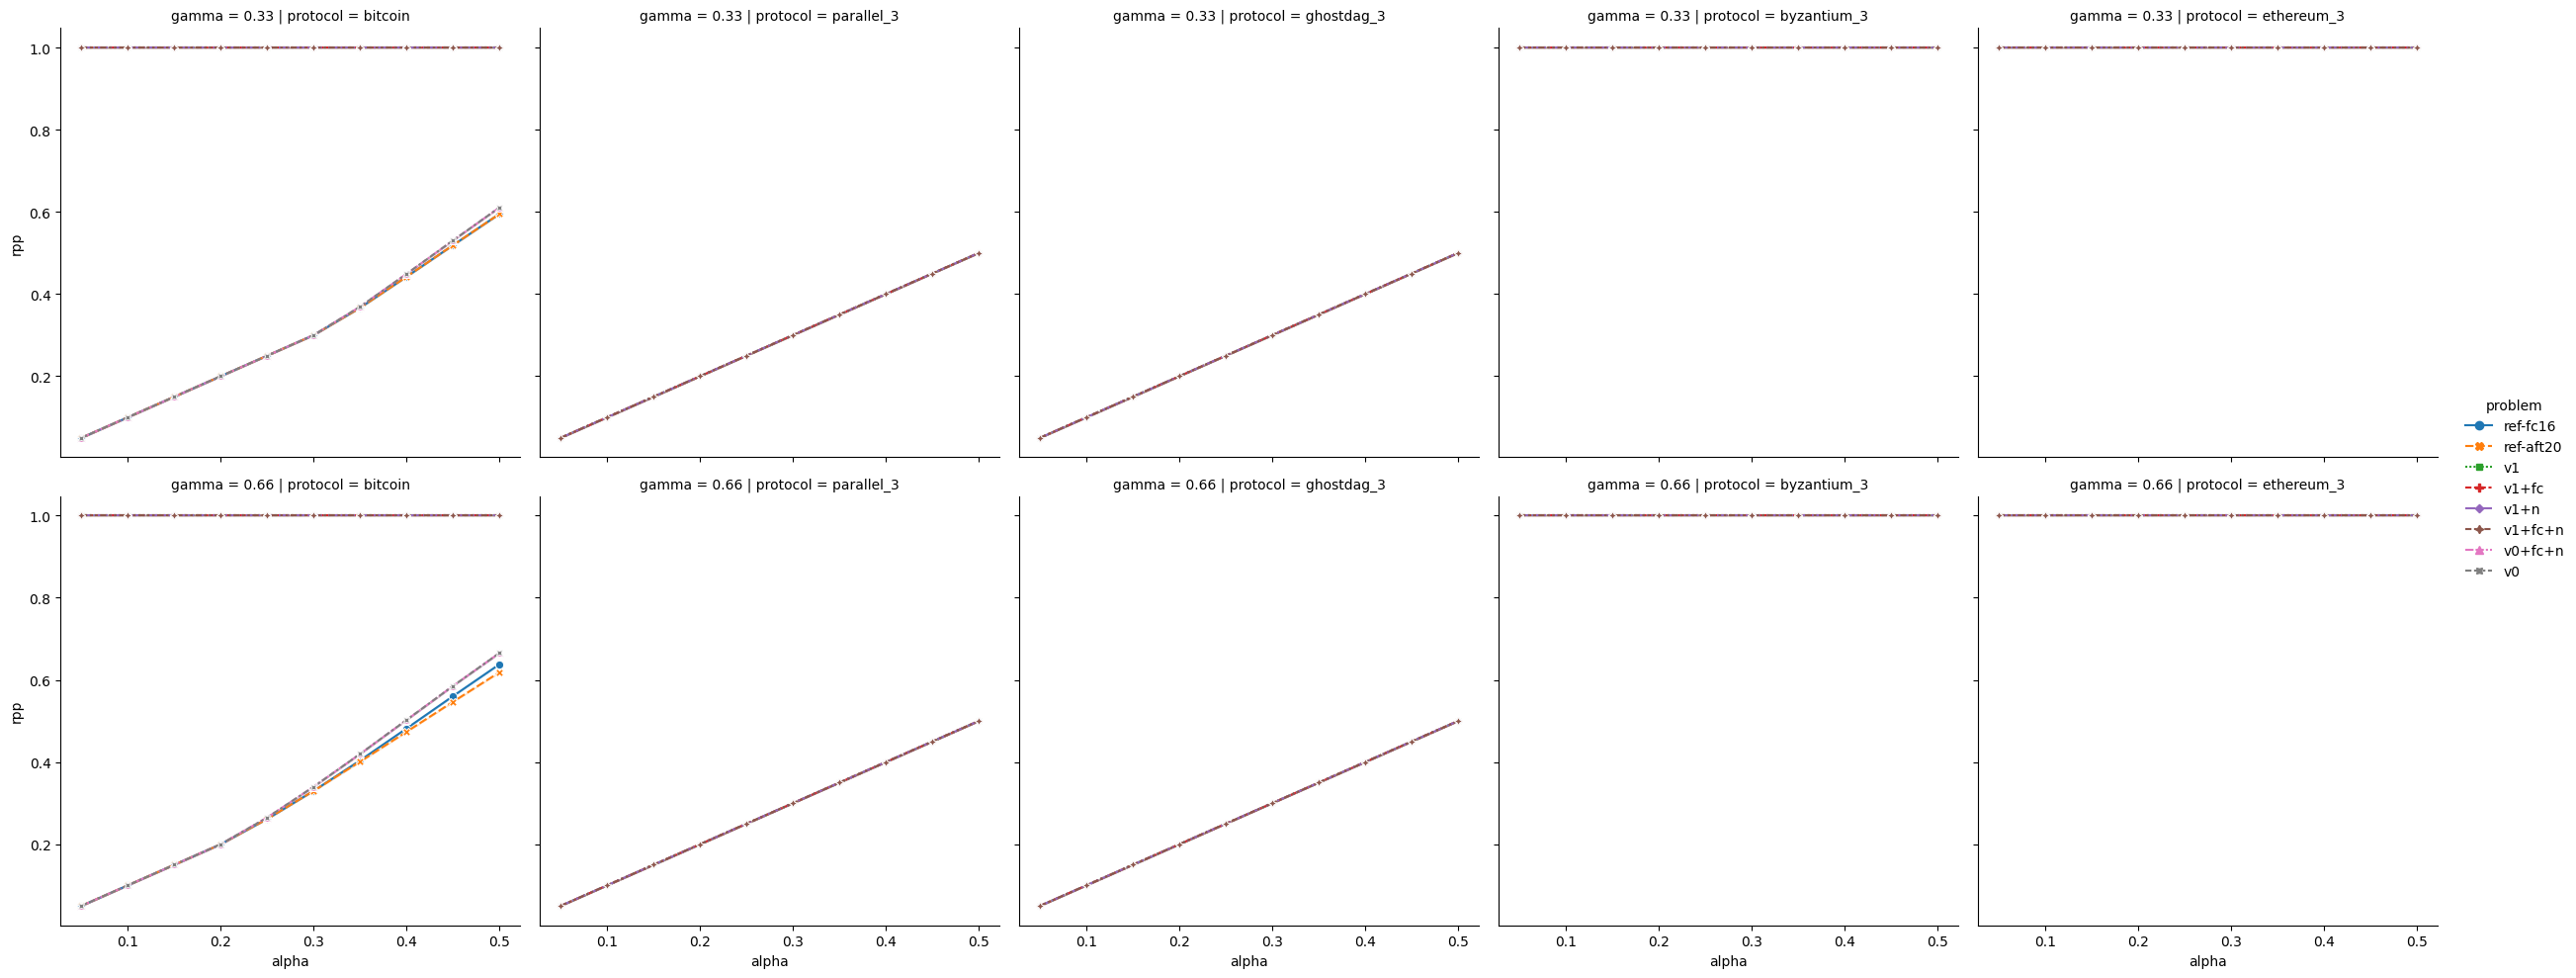

In [7]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="rpp",
    col="protocol",
    hue="problem",
    style="problem",
    markers=True,
    row="gamma",
)

# Revenue, PTO model, at source-model steady state

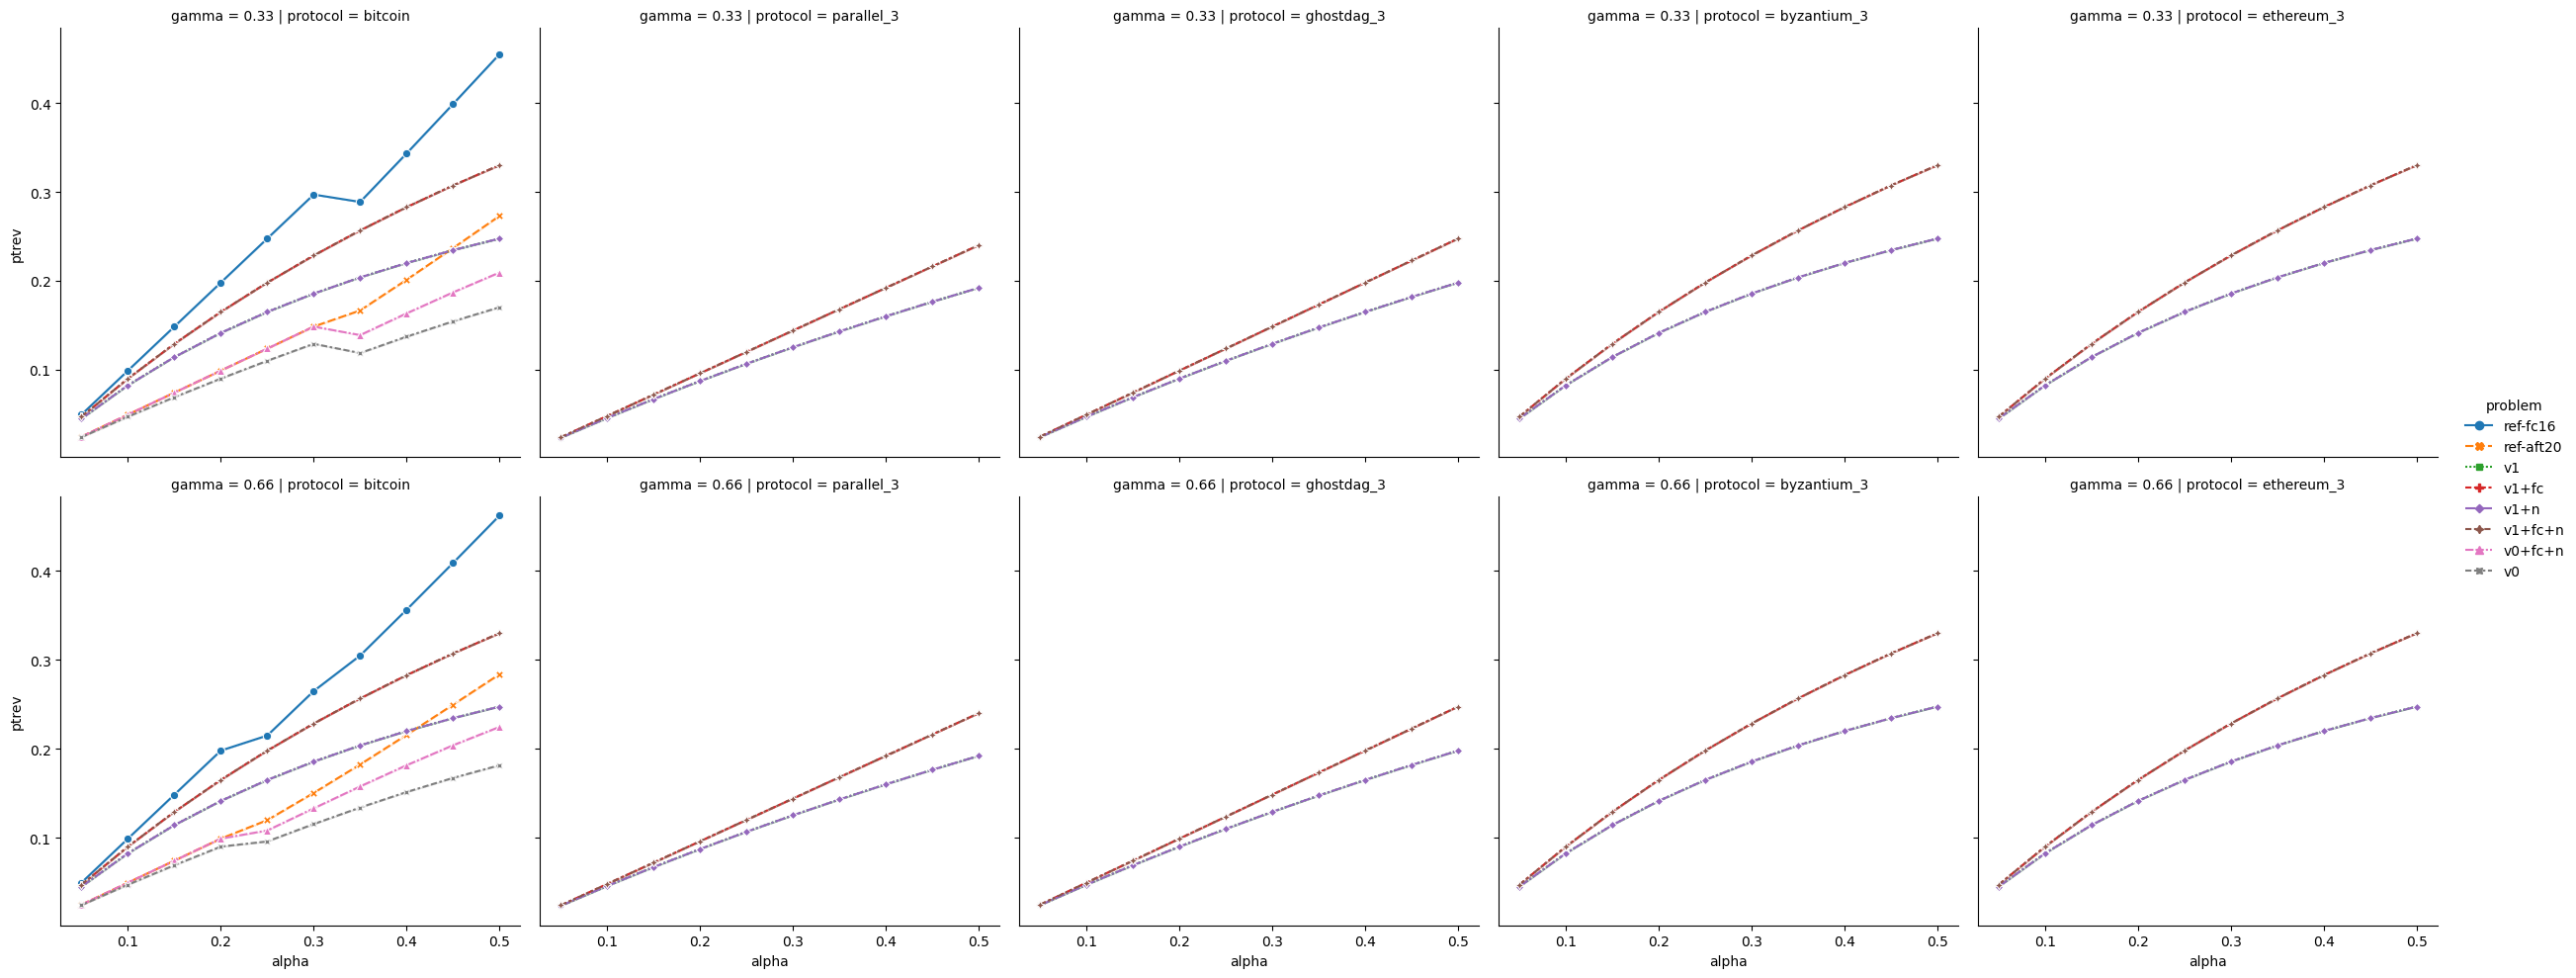

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="ptrev",
    col="protocol",
    hue="problem",
    style="problem",
    markers=True,
    row="gamma",
)